<a href="https://colab.research.google.com/github/Pannaga01/DL_project/blob/main/CNN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INVASIVE SPECIES CLASSIFICATION-CNN**

Arya RN (AM.EN.U4CSE19209)

Pannaga Sreya (AM.EN.U4CSE19258)

Deepthi.A (AM.EN.U4CSE19208)

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


## Load Data

In [ ]:
!kaggle competitions download -c invasive-species-monitoring

  0% 0.00/6.19k [00:00<?, ?B/s]
100% 6.19k/6.19k [00:00<00:00, 5.47MB/s]
100% 1.97G/1.98G [00:29<00:00, 44.5MB/s]
100% 1.98G/1.98G [00:29<00:00, 71.2MB/s]
 99% 1.13G/1.14G [00:17<00:00, 42.9MB/s]
100% 1.14G/1.14G [00:17<00:00, 71.2MB/s]
  0% 0.00/4.18k [00:00<?, ?B/s]
100% 4.18k/4.18k [00:00<00:00, 4.40MB/s]


In [ ]:
!unzip train_labels.csv.zip
!unzip sample_submission.csv.zip
!7z e '/content/train.7z' -o'/content/train'
!7z e '/content/test.7z' -o'/content/test'

Archive:  train_labels.csv.zip
  inflating: train_labels.csv        
   creating: __MACOSX/
  inflating: __MACOSX/._train_labels.csv  
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
  inflating: __MACOSX/._sample_submission.csv  

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 2126278821 bytes (2028 MiB)

Extracting archive: /content/train.7z
--
Path = /content/train.7z
Type = 7z
Physical Size = 2126278821
Headers Size = 24792
Method = LZMA2:24
Solid = +
Blocks = 2

  0%      0% 1        0% 4 - train/1000.jpg                         0% 8 - train/1004.jpg                         0% 13 - t

## Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, utils
from torch.utils.data import Dataset,DataLoader
from skimage import io, transform
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Train and Validation dataset

In [ ]:
train_label = pd.read_csv('/content/train_labels.csv')
files = train_label['name'] 
labels = train_label['invasive']
train_files,val_files,train_labels,val_labels = train_test_split(files,labels)

In [ ]:
print(train_files.shape,val_files.shape)

(1721,) (574,)


## Custom dataset

In [ ]:
class SpeciesDataset(Dataset):
    def __init__(self,root_dir,files,label = None,is_train = False,transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        self.files = files
        self.labels = label

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.files.iloc[idx]
        #print(img)
        imgpath = self.root_dir + '/' + str(img) +'.jpg'
        sample = plt.imread(imgpath)
        sample = sample.transpose()
        sample = torch.from_numpy(sample)
        if self.transform:
            sample = self.transform(sample)
        if self.labels is not None:
          return sample,self.labels.iloc[idx]
        else:
          return sample

In [ ]:
transform_image = torch.nn.Sequential(
    transforms.Resize([224,224])
)

In [ ]:
TrainDataset = SpeciesDataset(root_dir = '/content/train',files = train_files,label = train_labels,is_train = True,transform = transform_image)
ValidationDataset = SpeciesDataset('/content/train',files = val_files,label = val_labels,is_train = False,transform = transform_image)

In [ ]:
batch_size = 4

In [ ]:
trainloader = torch.utils.data.DataLoader(TrainDataset, batch_size=4, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)


torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
1


In [ ]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

In [ ]:
from torchvision import models

In [ ]:
googlenet = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## Dataloader

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(TrainDataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(ValidationDataset, batch_size=batch_size, shuffle=False)

## GoogLeNet

In [ ]:
googlenet = models.googlenet(pretrained = True)

In [ ]:
for param in googlenet.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 2

In [ ]:
final_in_features = googlenet.fc.in_features
googlenet.fc = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in googlenet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 1024])
torch.Size([2])


In [ ]:
googlenet = googlenet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(googlenet.parameters(), lr=0.05)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

## Training

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0/2, Test acc: 56.10, Train acc: 55.03
Epoch: 1/2, Test acc: 78.40, Train acc: 80.07


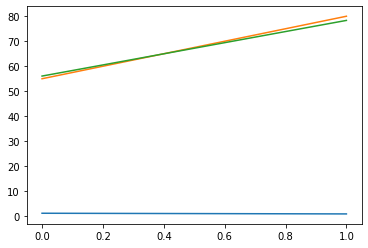

In [ ]:
loss_epoch_arr = []
train_accuracy = []
test_accuracy = []
max_epochs = 2
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = googlenet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        #if i % 100 == 0:
        #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    test_acc = evaluation(testloader, googlenet)
    train_acc = evaluation(trainloader, googlenet)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc,train_acc))
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
plt.plot(loss_epoch_arr)
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()

In [ ]:
print(loss_epoch_arr)

[1.1239678859710693, 0.8566552996635437]


In [ ]:
print(train_accuracy)

[55.02614758861127, 80.0697269029634]


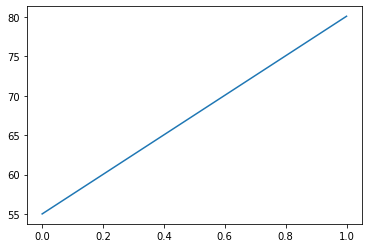

In [ ]:
plt.plot(train_accuracy)

In [ ]:
print(test_accuracy)

[56.09756097560975, 78.397212543554]


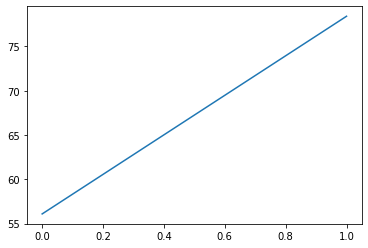

In [ ]:
plt.plot(test_accuracy)

## Hyperparameter tuning

sgd, momentum, lr

In [ ]:
opt = torch.optim.SGD(googlenet.parameters(), lr=0.01)

Epoch: 0/2, Test acc: 89.20, Train acc: 89.60
Epoch: 1/2, Test acc: 89.02, Train acc: 88.73


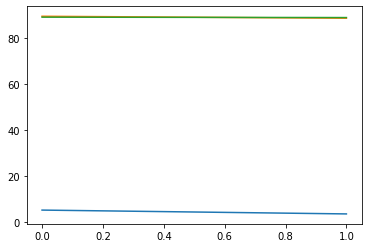

In [ ]:
loss_epoch_arr = []
train_accuracy = []
test_accuracy = []
max_epochs = 2
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = googlenet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        #if i % 100 == 0:
        #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    test_acc = evaluation(testloader, googlenet)
    train_acc = evaluation(trainloader, googlenet)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc,train_acc))
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
plt.plot(loss_epoch_arr)
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()

In [ ]:
opt = torch.optim.SGD(googlenet.parameters(), lr=0.01, momentum=0.9)

Epoch: 0/2, Test acc: 85.89, Train acc: 87.91
Epoch: 1/2, Test acc: 70.73, Train acc: 76.00


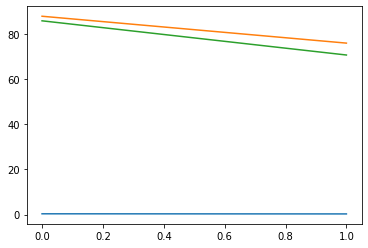

In [ ]:
loss_epoch_arr = []
train_accuracy = []
test_accuracy = []
max_epochs = 2
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = googlenet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        #if i % 100 == 0:
        #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    test_acc = evaluation(testloader, googlenet)
    train_acc = evaluation(trainloader, googlenet)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc,train_acc))
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
plt.plot(loss_epoch_arr)
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()

In [ ]:
opt = torch.optim.SGD(googlenet.parameters(), lr=0.01, momentum=0.5)

Epoch: 0/2, Test acc: 87.46, Train acc: 89.19
Epoch: 1/2, Test acc: 83.45, Train acc: 88.44


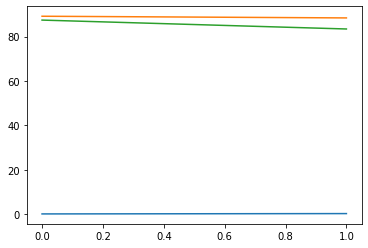

In [ ]:
loss_epoch_arr = []
train_accuracy = []
test_accuracy = []
max_epochs = 2
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = googlenet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        #if i % 100 == 0:
        #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    test_acc = evaluation(testloader, googlenet)
    train_acc = evaluation(trainloader, googlenet)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc,train_acc))
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
plt.plot(loss_epoch_arr)
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()

In [ ]:
opt = torch.optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.1)

Epoch: 0/2, Test acc: 90.24, Train acc: 89.02
Epoch: 1/2, Test acc: 86.24, Train acc: 88.67


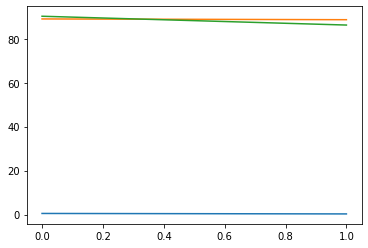

In [ ]:
loss_epoch_arr = []
train_accuracy = []
test_accuracy = []
max_epochs = 2
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = googlenet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        #if i % 100 == 0:
        #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    test_acc = evaluation(testloader, googlenet)
    train_acc = evaluation(trainloader, googlenet)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc,train_acc))
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
plt.plot(loss_epoch_arr)
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()

### Nesterov

In [ ]:
googlenet1 = models.googlenet(pretrained = True)

In [ ]:
for param in googlenet1.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 2

In [ ]:
final_in_features = googlenet1.fc.in_features
googlenet1.fc = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in googlenet1.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 1024])
torch.Size([2])


In [ ]:
googlenet1 = googlenet1.to(device)
loss_fn = nn.CrossEntropyLoss()
opt1 = torch.optim.SGD(googlenet.parameters(), lr=0.0009,momentum = 0.00001,nesterov=True)

Epoch: 0/2, Test acc: 62.54, Train acc: 63.16
Epoch: 1/2, Test acc: 62.20, Train acc: 64.73


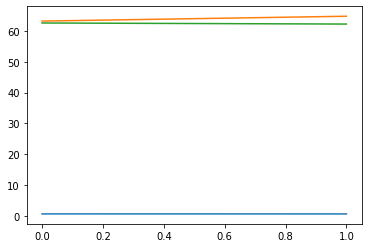

In [ ]:
loss_epoch_arr1 = []
train_accuracy1 = []
test_accuracy1 = []
max_epochs = 2
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr1 = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt1.zero_grad()
        outputs = googlenet1(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt1.step()
        loss_arr.append(loss.item())
        #if i % 100 == 0:
        #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr1.append(loss.item())
    test_acc1 = evaluation(testloader, googlenet1)
    train_acc1 = evaluation(trainloader, googlenet1)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc1,train_acc1))
    train_accuracy1.append(train_acc1)
    test_accuracy1.append(test_acc1)
plt.plot(loss_epoch_arr1)
plt.plot(train_accuracy1)
plt.plot(test_accuracy1)
plt.show()

### Adagrad

In [ ]:
googlenet2 = models.googlenet(pretrained = True)

In [ ]:
for param in googlenet2.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 2

In [ ]:
final_in_features = googlenet2.fc.in_features
googlenet2.fc = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in googlenet2.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 1024])
torch.Size([2])


In [ ]:
googlenet2 = googlenet2.to(device)
loss_fn = nn.CrossEntropyLoss()
opt2 = torch.optim.Adagrad(googlenet.parameters(), lr=0.0009)

Epoch: 0/2, Test acc: 61.85, Train acc: 61.07
Epoch: 1/2, Test acc: 60.98, Train acc: 58.34


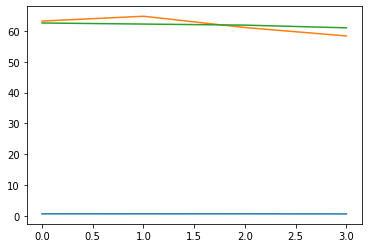

In [ ]:
loss_epoch_arr2 = []
train_accuracy2 = []
test_accuracy2 = []
max_epochs = 2
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr1 = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt1.zero_grad()
        outputs = googlenet2(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt1.step()
        loss_arr.append(loss.item())
        #if i % 100 == 0:
        #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr1.append(loss.item())
    test_acc1 = evaluation(testloader, googlenet2)
    train_acc1 = evaluation(trainloader, googlenet2)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc1,train_acc1))
    train_accuracy1.append(train_acc1)
    test_accuracy1.append(test_acc1)
plt.plot(loss_epoch_arr1)
plt.plot(train_accuracy1)
plt.plot(test_accuracy1)
plt.show()

# Resnet

In [ ]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 2

In [ ]:
final_in_features = resnet.fc.in_features
resnet.fc = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 512])
torch.Size([2])


In [ ]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(resnet.parameters(), lr=0.05)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device,dtype=torch.float32), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0/2, Test acc: 78.40, Train acc: 83.79
Epoch: 1/2, Test acc: 66.90, Train acc: 70.37


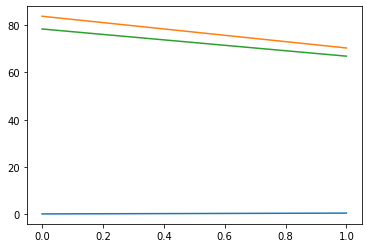

In [ ]:
loss_epoch_arr = []
train_accuracy = []
test_accuracy = []
max_epochs = 2
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device,dtype=torch.float32), labels.to(device)
        opt.zero_grad()
        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    test_acc = evaluation(testloader, resnet)
    train_acc = evaluation(trainloader, resnet)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc,train_acc))
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
plt.plot(loss_epoch_arr)
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()

# Densenet

In [ ]:
densenet = models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [ ]:
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
for param in densenet.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 2

In [ ]:
final_in_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in densenet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 2208])
torch.Size([2])


In [ ]:
densenet = densenet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(densenet.parameters(), lr=0.001,momentum = 0.1)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device,dtype=torch.float32), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Epoch: 0/3, Test acc: 87.11, Train acc: 93.09
Epoch: 1/3, Test acc: 87.63, Train acc: 92.16
Epoch: 2/3, Test acc: 88.68, Train acc: 91.52


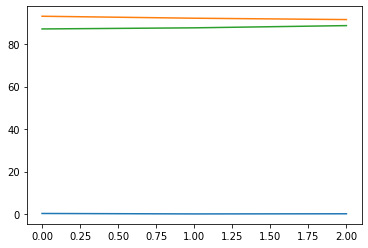

In [ ]:
loss_epoch_arr = []
train_accuracy = []
test_accuracy = []
max_epochs = 3
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device,dtype=torch.float32), labels.to(device)
        opt.zero_grad()
        #print(inputs.dtype)
        outputs = densenet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        #if i % 100 == 0:
        #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    test_acc = evaluation(testloader, densenet)
    train_acc = evaluation(trainloader, densenet)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc,train_acc))
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
plt.plot(loss_epoch_arr)
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()

# VGG

In [ ]:
vgg16 = models.vgg16(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in vgg16.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 2

In [ ]:
final_in_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in vgg16.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 4096])
torch.Size([2])


In [ ]:
vgg16 = vgg16.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(vgg16.parameters(), lr=0.001,momentum = 0.1)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device,dtype=torch.float32), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Epoch: 0/5, Test acc: 78.40, Train acc: 76.12
Epoch: 1/5, Test acc: 71.25, Train acc: 73.56
Epoch: 2/5, Test acc: 69.69, Train acc: 71.93
Epoch: 3/5, Test acc: 78.40, Train acc: 77.75
Epoch: 4/5, Test acc: 73.00, Train acc: 71.70


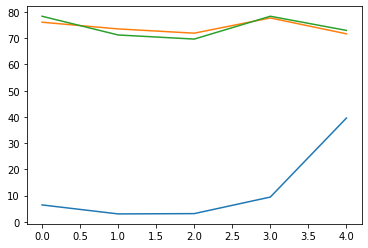

In [ ]:
loss_epoch_arr = []
train_accuracy = []
test_accuracy = []
max_epochs = 5
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device,dtype=torch.float32), labels.to(device)
        opt.zero_grad()
        #print(inputs.dtype)
        outputs = vgg16(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        #if i % 100 == 0:
        #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    test_acc = evaluation(testloader, vgg16)
    train_acc = evaluation(trainloader, vgg16)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc,train_acc))
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
plt.plot(loss_epoch_arr)
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()

# Mobilenet

In [ ]:
mobilenet = models.mobilenet_v2(pretrained=True)

In [ ]:
print(mobilenet)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [ ]:
for param in mobilenet.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 2

In [ ]:
final_in_features = mobilenet.classifier[1].in_features
mobilenet.classifier = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in mobilenet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 1280])
torch.Size([2])


In [ ]:
mobilenet = mobilenet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(mobilenet.parameters(), lr=0.001,momentum = 0.1)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device,dtype=torch.float32), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Epoch: 0/3, Test acc: 73.52, Train acc: 77.28
Epoch: 1/3, Test acc: 83.45, Train acc: 83.85
Epoch: 2/3, Test acc: 82.40, Train acc: 84.49


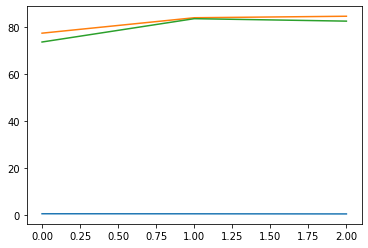

In [ ]:
loss_epoch_arr = []
train_accuracy = []
test_accuracy = []
max_epochs = 3
n_iters = np.ceil(trainloader.__len__()/batch_size)
loss_arr = []
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device,dtype=torch.float32), labels.to(device)
        opt.zero_grad()
        outputs = mobilenet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    test_acc = evaluation(testloader, mobilenet)
    train_acc = evaluation(trainloader, mobilenet)
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,test_acc,train_acc))
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
plt.plot(loss_epoch_arr)
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.show()